# Sea ice characteristics 
In this notebook, we'll highlight variables from the ICESat-2 dataset that describe important characteristics of the sea ice: snow depth, ice type, and snow density. We'll use cartopy and xarray to generate maps and lineplots of the data to demonstrate methods for visualizing the data statically, as opposed to the interactive plotting functions highlighted in the sea ice thickness notebook.

In [1]:
import xarray as xr # For working with gridded climate data 
import pandas as pd
import numpy as np
from utils.read_data_utils import read_book_data # Helper function for reading the data from the bucket
from utils.misc_utils import restrictRegionally # Region restriction 

# Plotting dependencies
import cartopy.crs as ccrs
from textwrap import wrap
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh # Helps avoid some weird issues with the polar projection 
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 # Sets figure size in the notebook

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

# 1) Read in the data 

In [2]:
# Read in the data 
book_ds = read_book_data()

# Restrict to the Inner Arctic region
book_ds_innerArctic = restrictRegionally(book_ds, regionKeyList=[10,11,12,13,15]) 

# Grab variables of interest 
snow_depth = book_ds_innerArctic["snow_depth"]
ice_type = book_ds_innerArctic["ice_type"]
snow_density = book_ds_innerArctic["snow_density"]

Regions selected: Inner Arctic


# 2) Map mean values for each winter season
Next, we'll compute gridcell means for each month for each variable. Then, we'll plot the means on a map of the Arctic, and display them next to each other for easy visual comparison. 

In [3]:
def compute_3winter_gridcell_means(da): 
    # Get pandas date ranges for each winter season 
    winter18_19 = pd.date_range(start="Nov 2018", end="Apr 2019", freq="MS")
    winter19_20 = pd.date_range(start="Nov 2019", end="Apr 2020", freq="MS")
    winter20_21 = pd.date_range(start="Nov 2020", end="Apr 2021", freq="MS")

    # Compute gridcell means 
    mean18_19 = da.sel(time=winter18_19).mean(dim="time", keep_attrs=True)
    mean19_20 = da.sel(time=winter19_20).mean(dim="time", keep_attrs=True)
    mean20_21 = da.sel(time=winter20_21).mean(dim="time", keep_attrs=True)
    
    # Assign descriptive time coordinate
    mean18_19 = mean18_19.assign_coords({"time":"Nov 2018 - Apr 2019"})
    mean19_20 = mean19_20.assign_coords({"time":"Nov 2019 - Apr 2020"})
    mean20_21 = mean20_21.assign_coords({"time":"Nov 2020 - Apr 2021"})
    
    # Assign time as a dimension
    mean18_19 = mean18_19.expand_dims("time")
    mean19_20 = mean19_20.expand_dims("time")
    mean20_21 = mean20_21.expand_dims("time")
    
    # Merge xr.DataArrays into one xr.Dataset object with each winter mean as a coordinate/dimension
    winter_means_all = xr.merge([mean18_19, mean19_20, mean20_21])
    winter_means_all["time"].attrs["description"] =  "winter season over which mean was computed" # Add descriptive attribute 
    winter_means_all_da = winter_means_all[da.name] # Convert Dataset to DataArray
    
    return winter_means_all_da

In [4]:
def plotArcticMaps(da, minval=None, maxval=None, title="", cmap="viridis", col_wrap=3, vmin=None, vmax=None): 
    """ Show data on a basemap of the Arctic. Can be one month or multiple months of data. 
    Creates an xarray facet grid. For more info, see: http://xarray.pydata.org/en/stable/user-guide/plotting.html
    
    Args: 
        da (xr DataArray): data to plot
        cmap (str, optional): colormap to use (default to viridis)
        col_wrap (int, optional): number of columns of plots to display (default to 3, or None if time dimension has only one value)
        vmin, vmax (float, optional): min and max on colorbar (default to xarray defaults)
    Returns:
        Figure displayed in notebook 
    
    """ 
    # Assign time coordinate if it doesn't exist
    try: 
        da.time
    except AttributeError: 
        da = da.assign_coords({"time":"unknown"})
    
    col_wrap = col_wrap if sum(da.time.shape) >1 else None
    col = "time" if sum(da.time.shape) >1 else None
    im = da.plot(x="longitude", y="latitude", col_wrap=col_wrap, col=col, transform=ccrs.PlateCarree(), cmap=cmap, zorder=8, 
                 cbar_kwargs={'pad':0.02,'shrink': 0.8,'extend':'both'},
                 vmin=vmin, vmax=vmax, 
                 subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)})
    
    # Iterate through axes and add features 
    ax_iter = im.axes
    if type(ax_iter) != np.array: # If the data is just a single month, ax.iter returns an axis object. We need to iterate through a list or array
        ax_iter = np.array(ax_iter)
    for ax in ax_iter.flatten():
        ax.coastlines(linewidth=0.15, color = 'black', zorder = 10) # Coastlines
        ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5)    # Land
        ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5)  # Lakes
        ax.gridlines(draw_labels=False, linewidth=0.25, color='gray', alpha=0.7, linestyle='--', zorder=6) # Gridlines
        ax.set_extent([-179, 179, 50, 90], crs=ccrs.PlateCarree()) # Set extent to zoom in on Arctic
       
    plt.suptitle(title, fontsize=13, horizontalalignment="center", x=0.45, y=1.06, fontweight='medium')
    plt.show()

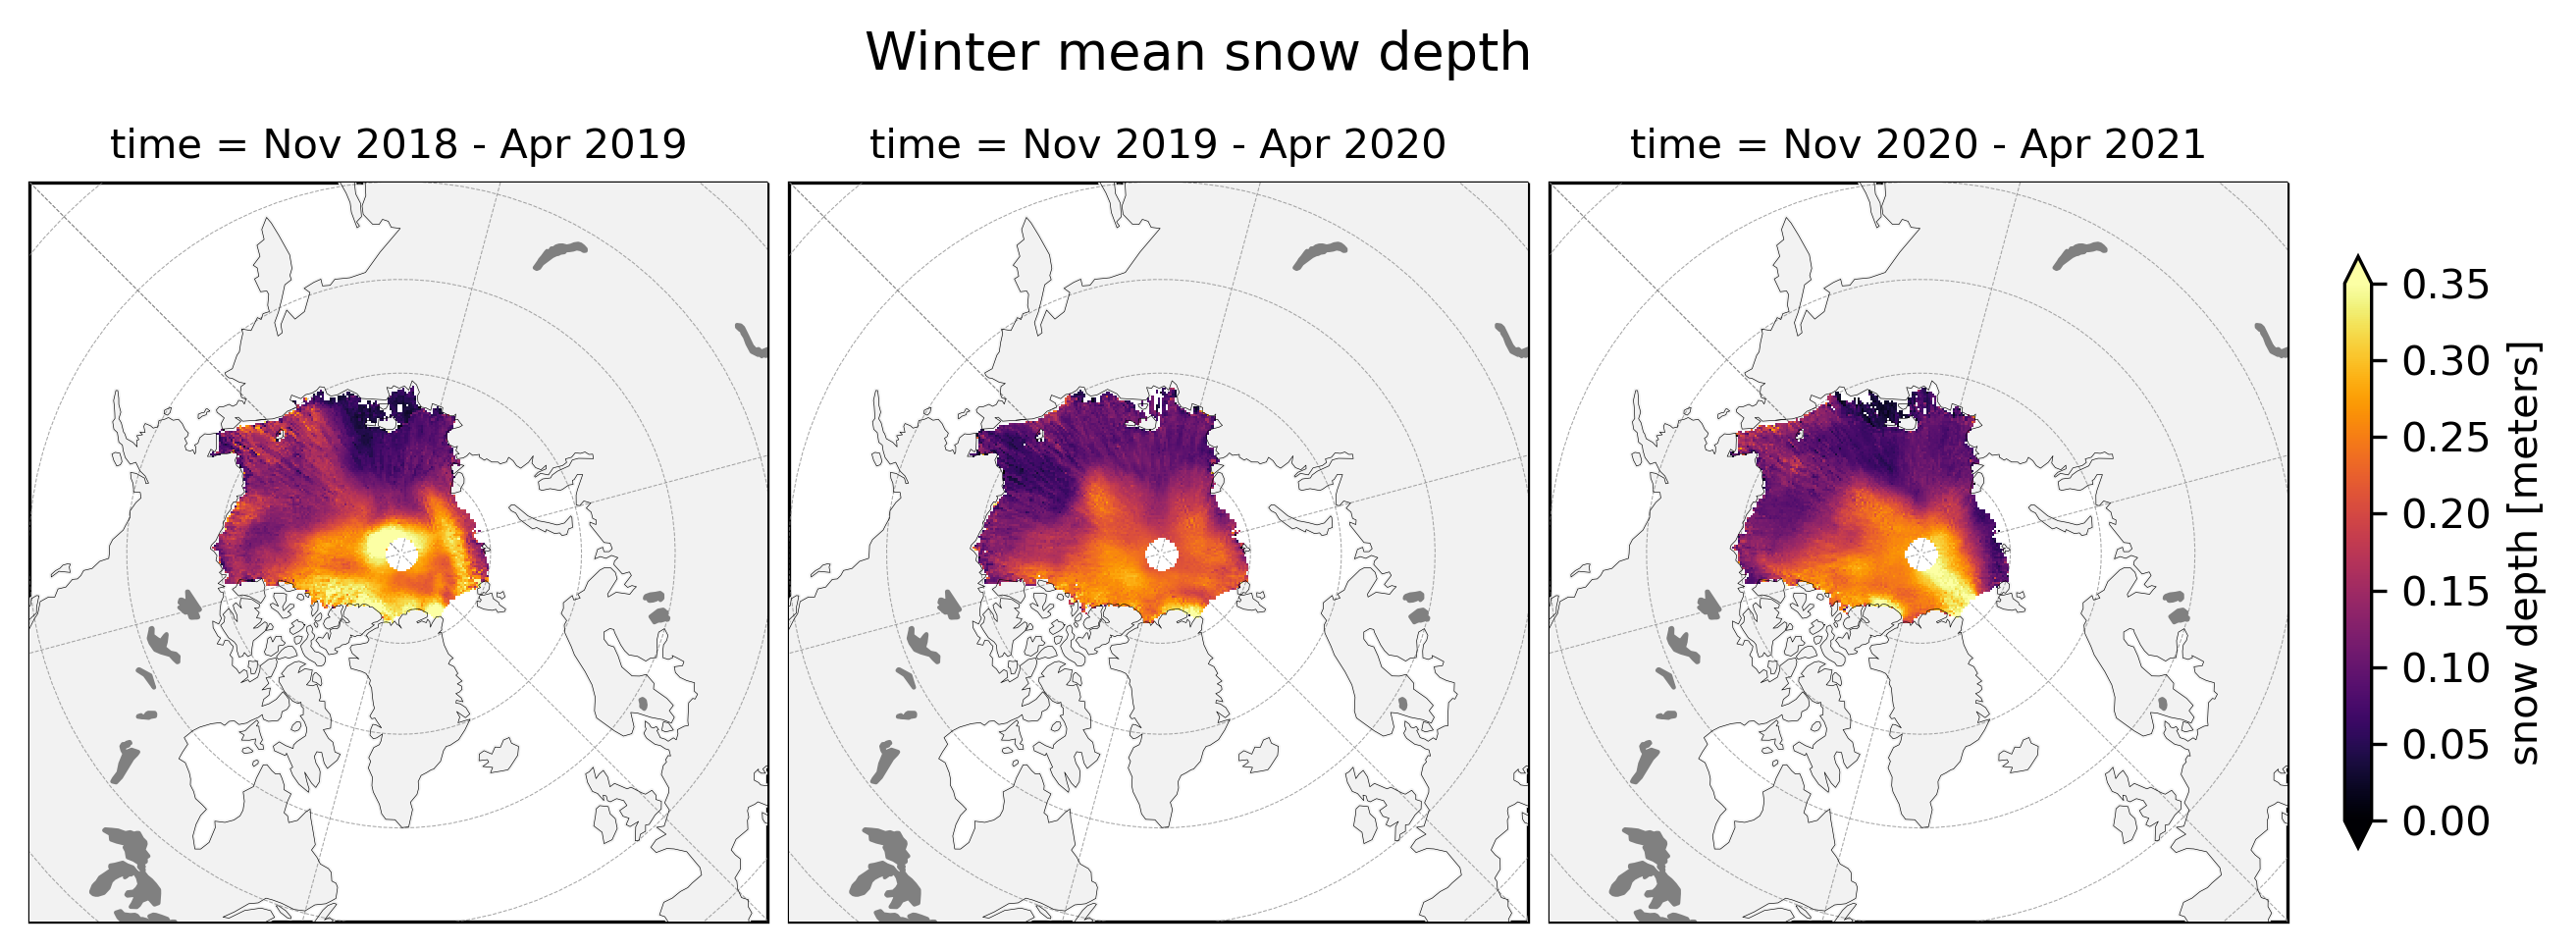

In [5]:
snow_depth_winter_means = compute_3winter_gridcell_means(snow_depth)
plotArcticMaps(snow_depth_winter_means, title="Winter mean snow depth", cmap="inferno", vmin=0, vmax=0.35)

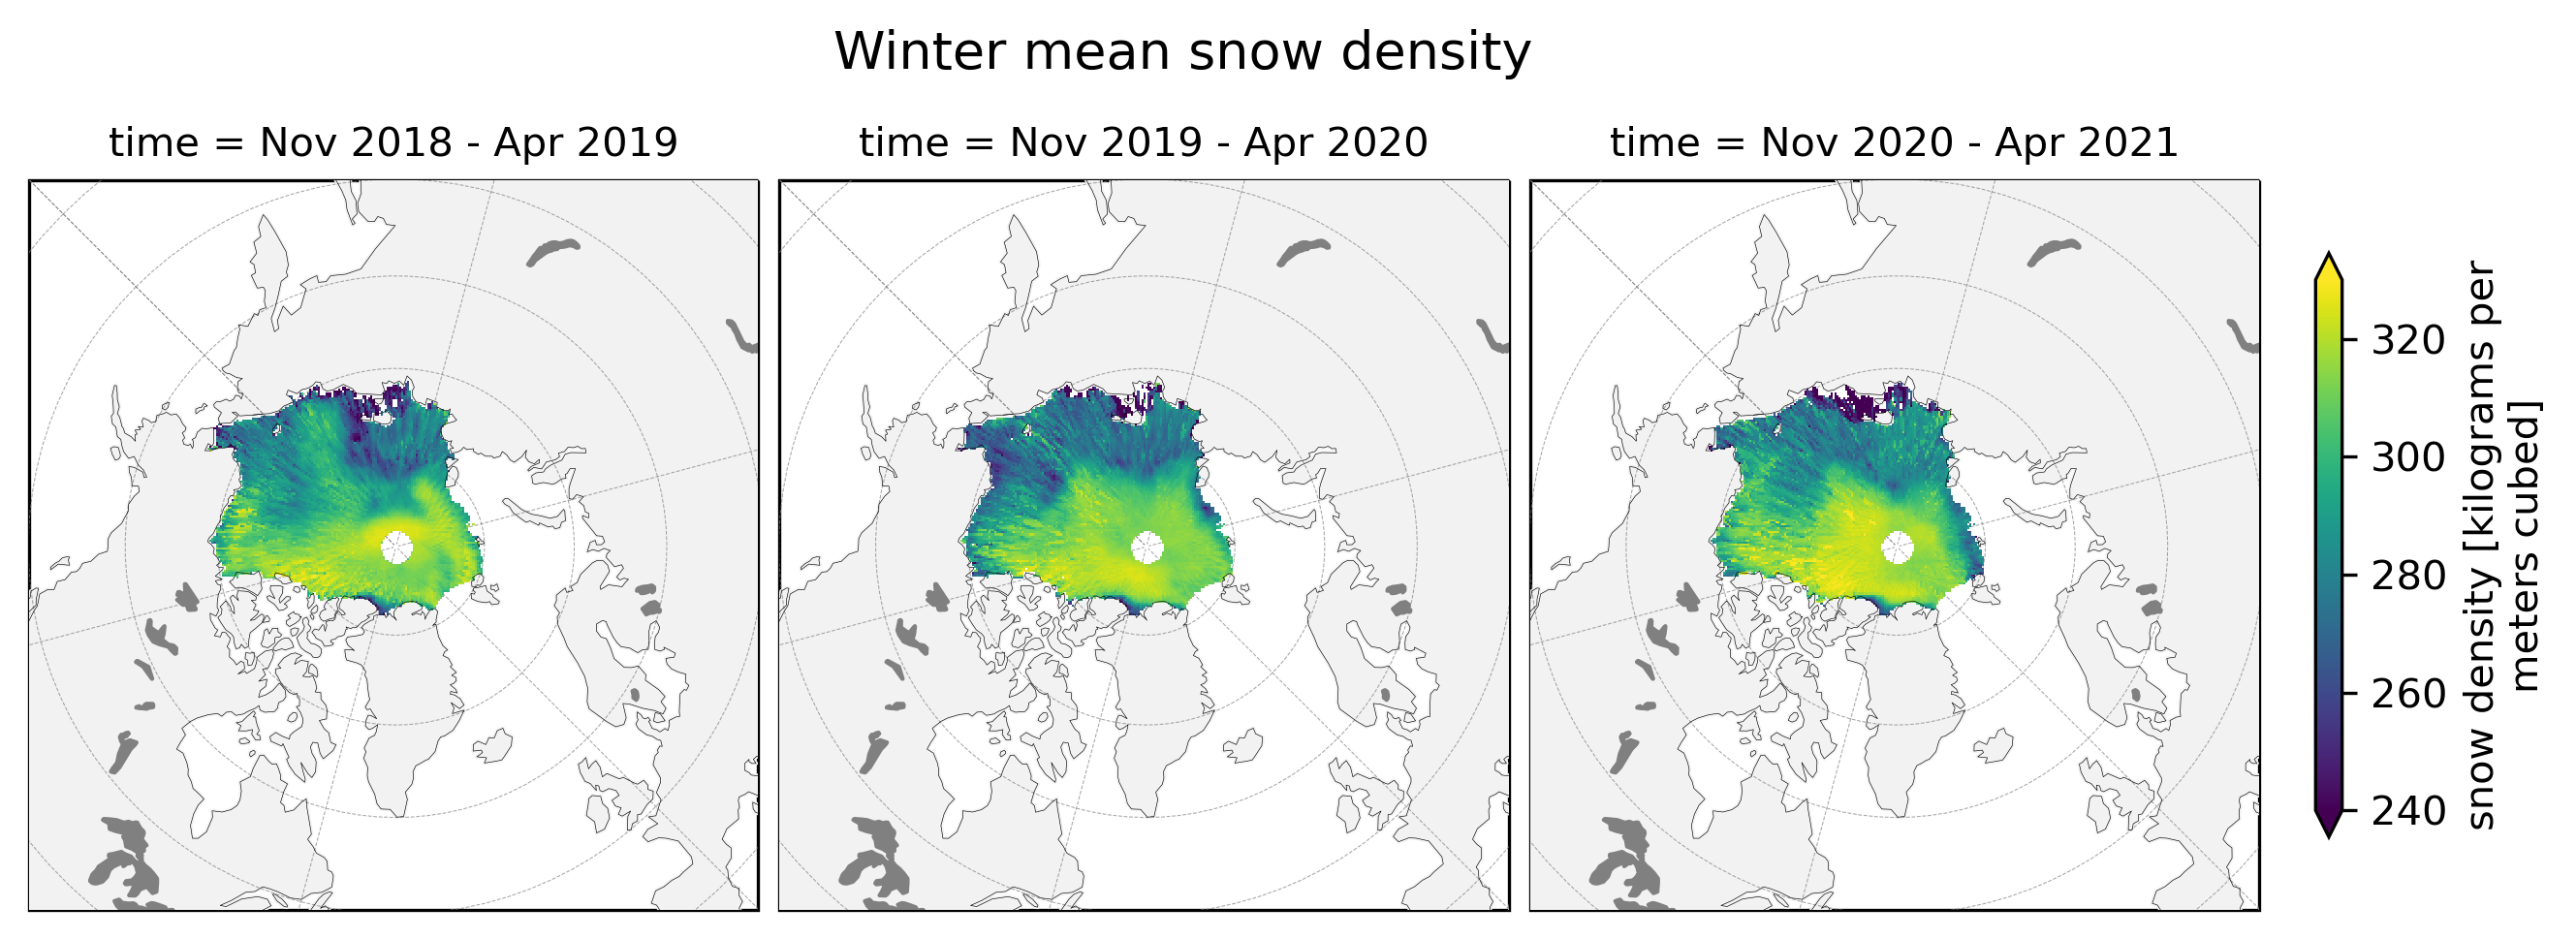

In [6]:
snow_density_winter_means = compute_3winter_gridcell_means(snow_density)
plotArcticMaps(snow_density_winter_means, title="Winter mean snow density", cmap="viridis", vmin=240, vmax=330)

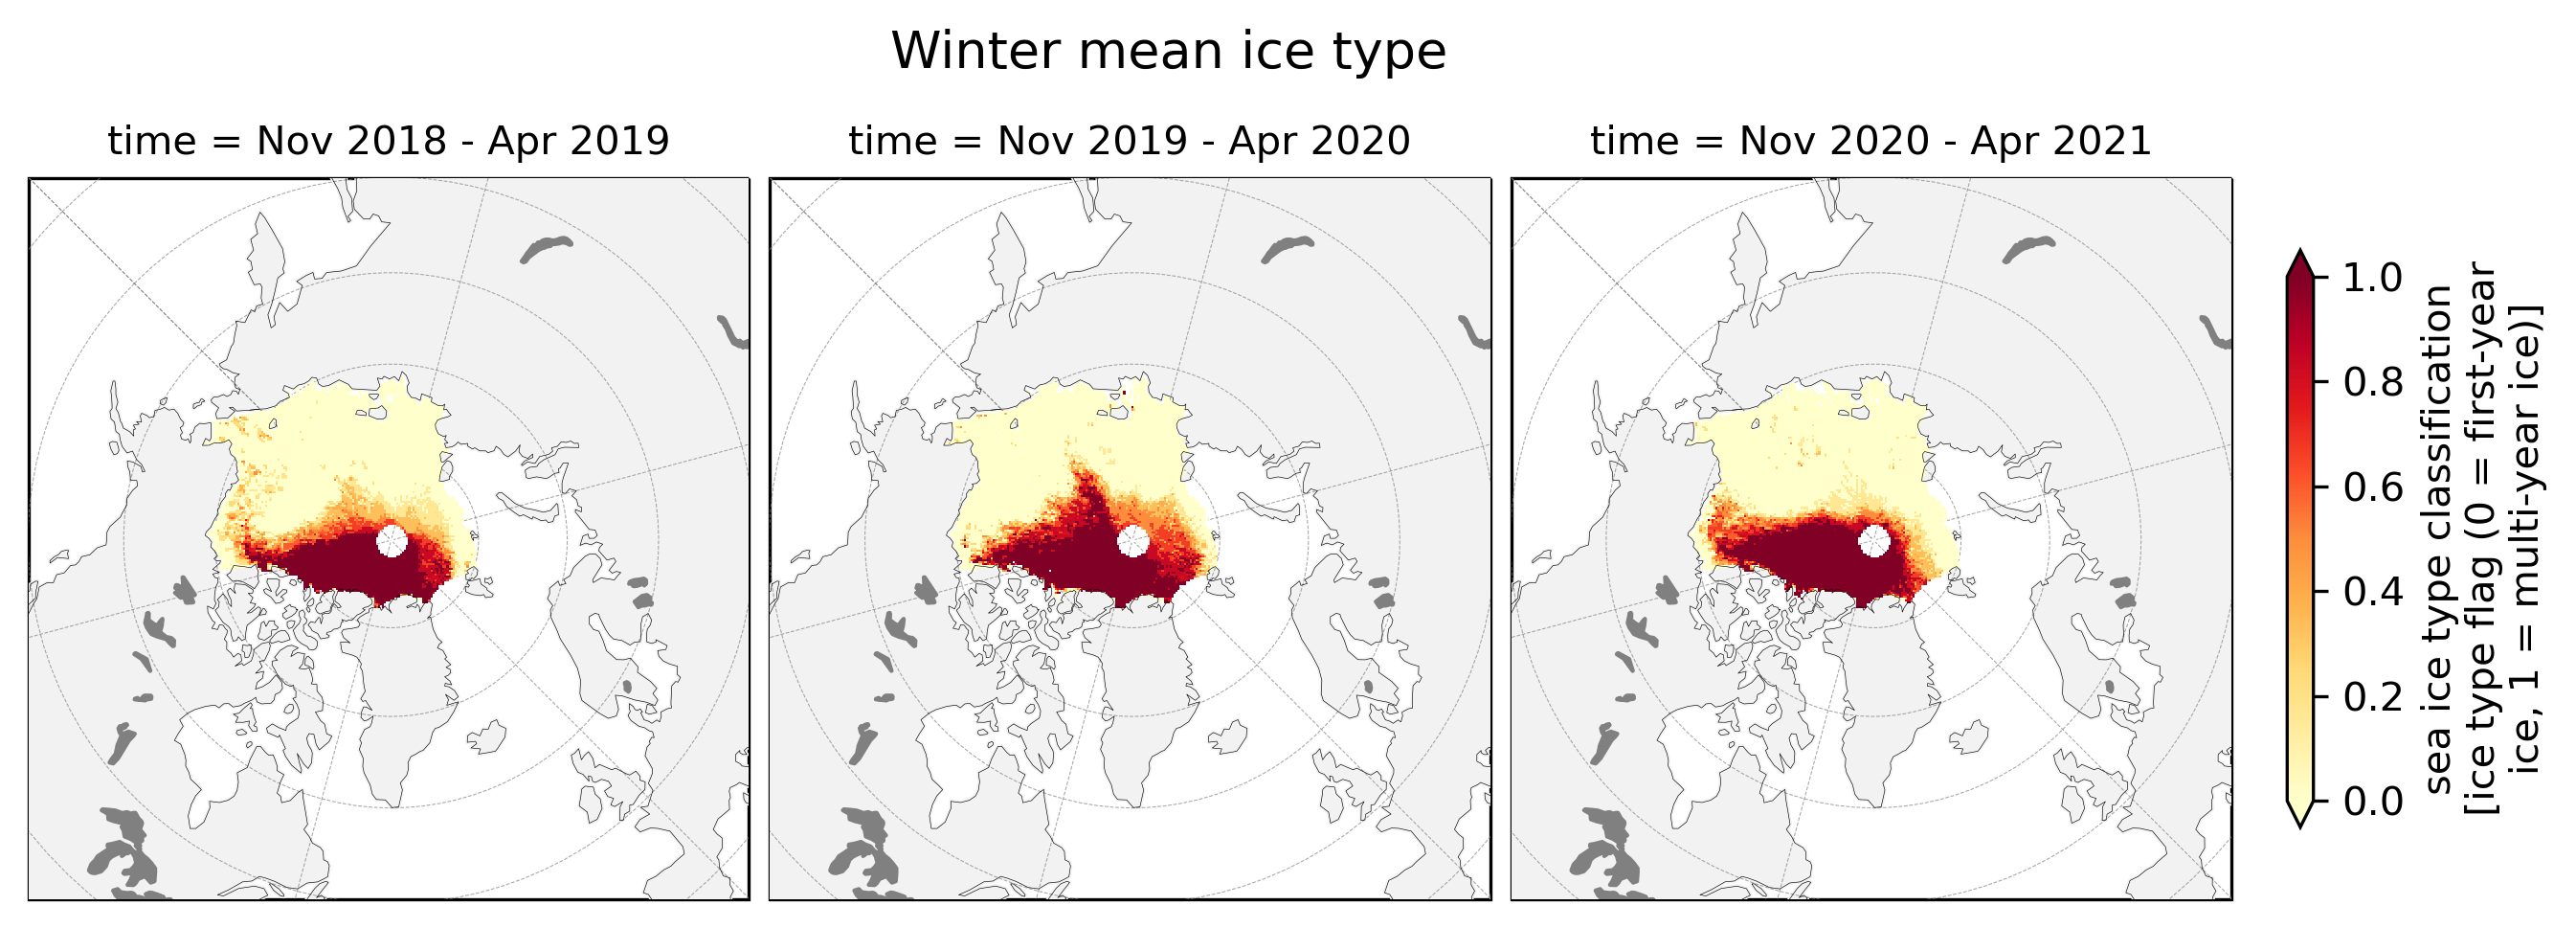

In [7]:
ice_type_winter_means = compute_3winter_gridcell_means(ice_type)
plotArcticMaps(ice_type_winter_means, title="Winter mean ice type", cmap="YlOrRd", vmin=0, vmax=1)

# 3) Monthly mean lineplots 
Next we'll compute the means by averaging over all the gridcells. We'll use this to generate a lineplot to compare across the three winter seasons for each variable.

In [21]:
def lineplot_3winter_monthly_means(da, title=None, figsize=(5,3)):
    # Get pandas date ranges for each winter season 
    winter18_19 = pd.date_range(start="Nov 2018", end="Apr 2019", freq="MS")
    winter19_20 = pd.date_range(start="Sep 2019", end="Apr 2020", freq="MS")
    winter20_21 = pd.date_range(start="Sep 2020", end="Apr 2021", freq="MS")

    # Compute gridcell means 
    mean18_19 = da.sel(time=winter18_19).mean(dim=["x","y"], keep_attrs=True)
    mean19_20 = da.sel(time=winter19_20).mean(dim=["x","y"], keep_attrs=True)
    mean20_21 = da.sel(time=winter20_21).mean(dim=["x","y"], keep_attrs=True)
    
    # Set up plot 
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(["Sep","Oct","Nov","Dec","Jan","Feb","Mar","Apr"], np.empty((8,1))*np.nan, color=None, label=None) # Set x axis using winter months 
    gridlines = plt.grid(b = True, linestyle = '--', alpha = 0.4) # Add gridlines 

    # Generate line plots for each DataArray 
    plt.plot(pd.to_datetime(mean18_19.time.values).strftime("%b"), mean18_19, color="c", marker='o', linestyle='-', label='Winter 2018-19')
    plt.plot(pd.to_datetime(mean19_20.time.values).strftime("%b"), mean19_20, color="m", marker='s', linestyle='--', label='Winter 2019-20')
    plt.plot(pd.to_datetime(mean20_21.time.values).strftime("%b"), mean20_21, color="y", marker='v', linestyle='-.', label='Winter 2020-21')

    # Add legend, title, and axis labels, and display plot in notebook 
    plt.legend(fontsize=7, loc="best")
    plt.title(title, fontsize=10)
    if "long_name" in da.attrs: 
        ylabel = da.attrs["long_name"]
        if "units" in da.attrs: 
            ylabel+=" ("+da.attrs["units"]+")"
        ylabel="\n".join(wrap(ylabel, 35))
    else: 
        ylabel=None
    plt.ylabel(ylabel, fontsize=9)
    plt.show()

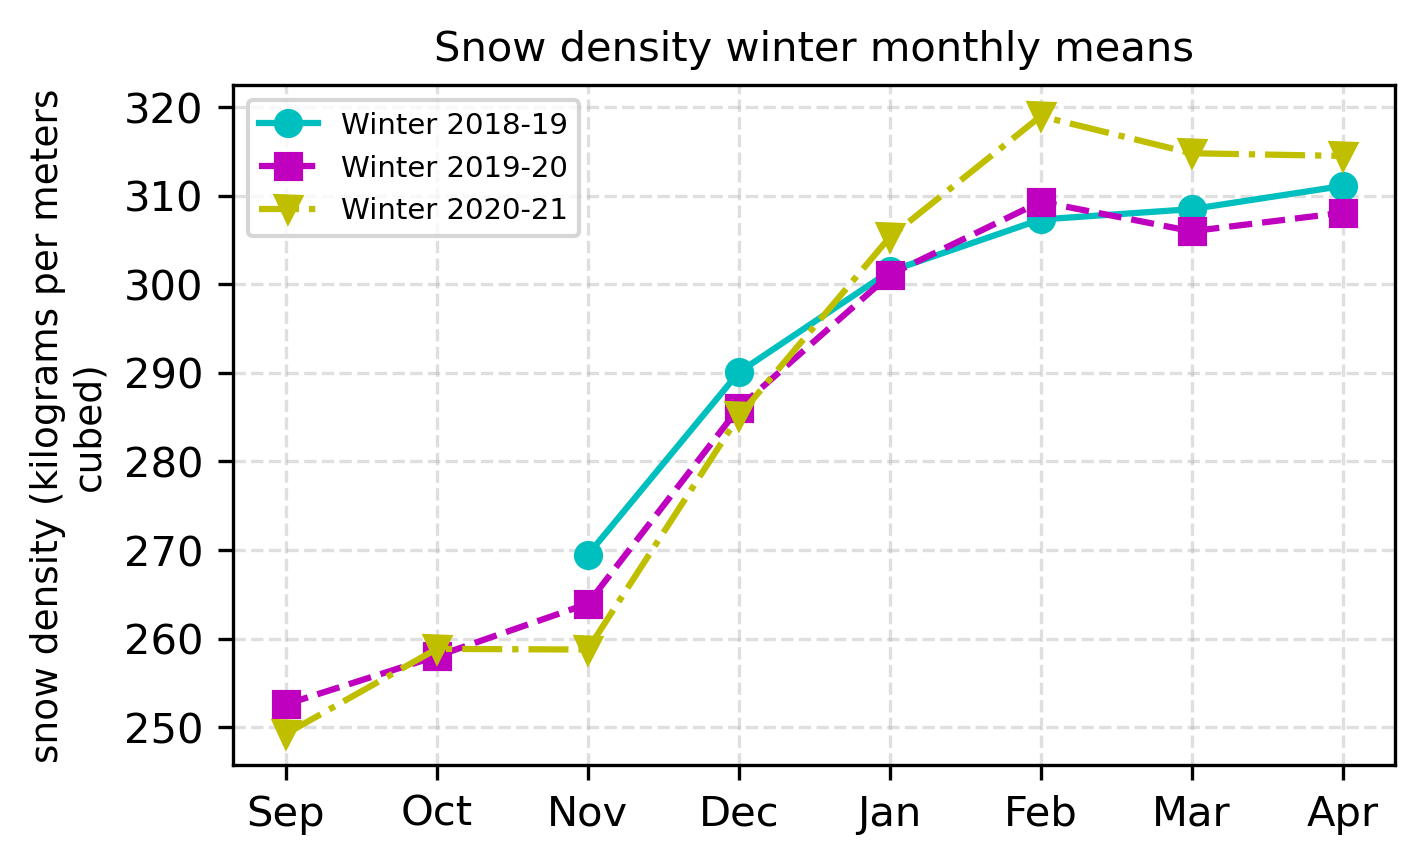

In [22]:
lineplot_3winter_monthly_means(snow_density, title="Snow density winter monthly means")

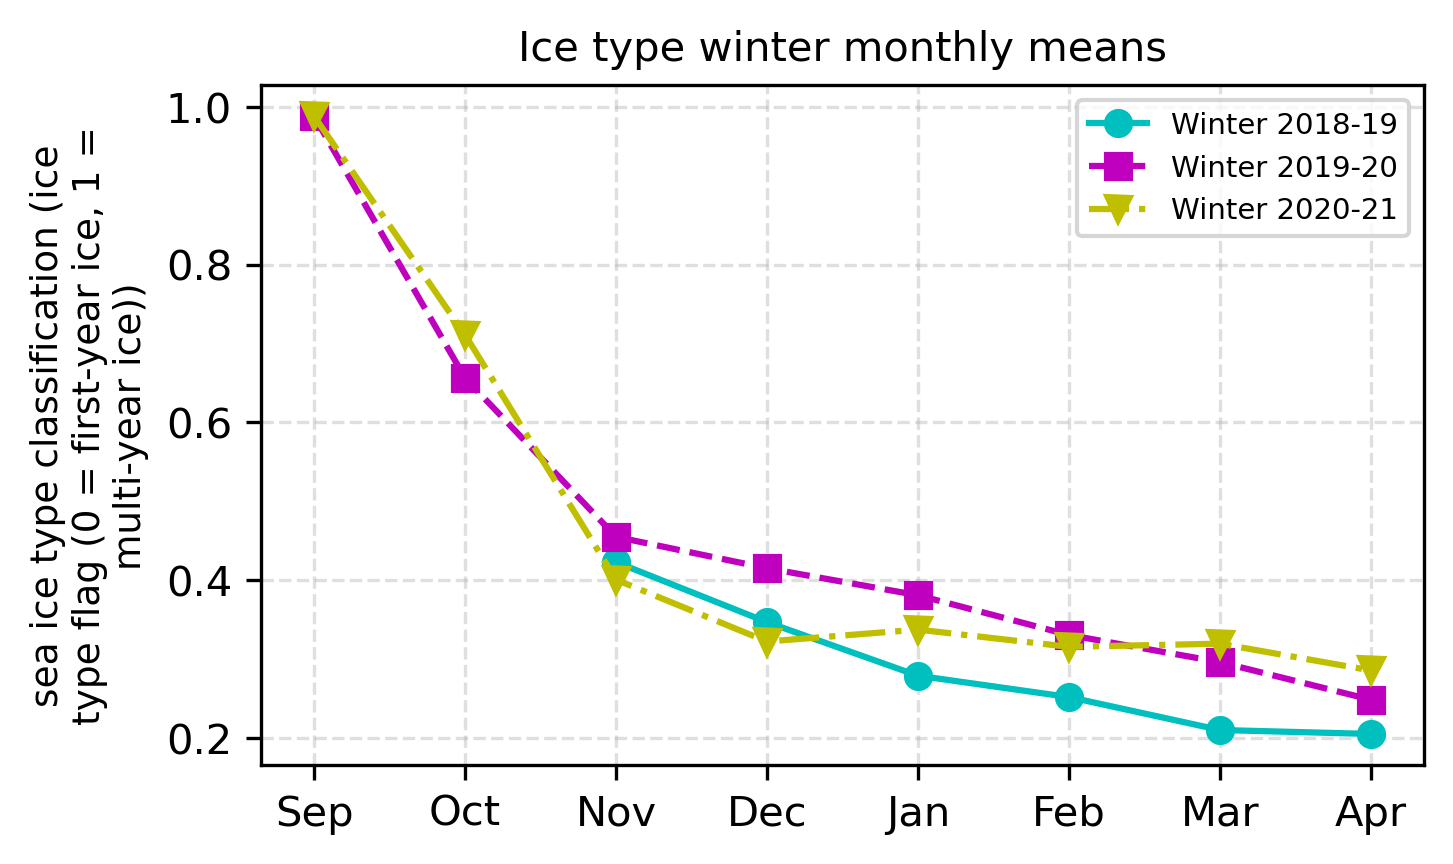

In [23]:
lineplot_3winter_monthly_means(ice_type, title="Ice type winter monthly means")

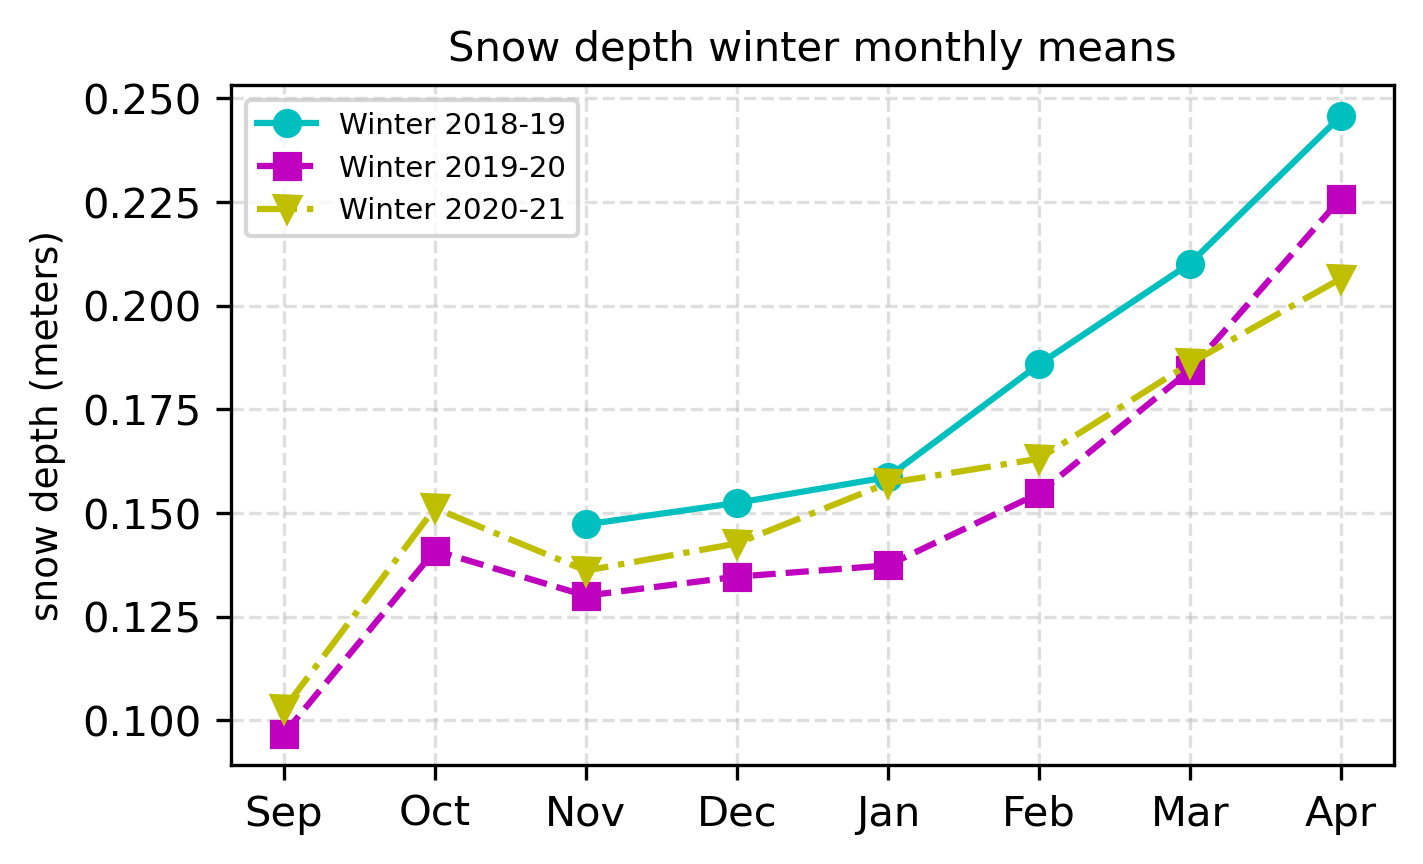

In [24]:
lineplot_3winter_monthly_means(snow_depth, title="Snow depth winter monthly means")